# Camera Calibration
The code in this notebook will later be broken apart into separate packages. Currently, this notebook is for prototyping.

Starting the experimentation with the test images.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import glob
from os import path

%matplotlib inline

In [2]:
"""
Calibrate the camera given a directory containing calibration chessboards.

param dir: directory containing chessboard frames
param nx: Chessboard corners on x axis
param ny: Chessboard corners on y axis
param img_prefix: The repeating prefix used to name calibration images
param img_type: Calibration image filetype
param verbose: if True, draw and show chessboard corners
return: calibration parameters
"""
def camera_calibration(dir="camera_cal", nx=9, ny=6, img_prefix = "", img_type="jpg", verbose=False):
    assert path.exists(dir), dir + " does not exist. Need a valid directory containing calibration images"
    # 3d points in real world space
    objpoints = []
    # 2d points in image plane
    imgpoints = []
    
    #prep objpoints so it looks like (0, 0, 0), (1, 0, 0), ... (nx, ny, 0)
    # the z coordinate is always zero
    objp = np.zeros((nx*ny, 3), np.float32)
    
    # mgrid returns the coordinate values for a given grid size --> [nx, ny]
    # we are shaping the coordinates from mgrid back into 2 columns --> (x, y)
    # this is to create image points, look at distorted calibration image and detect corners
    # of board
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    images = glob.glob(path.join(dir,img_prefix+"*."+img_type))
    
    assert len(images) > 0, "There are no images to calibrate the camere."
    
    for file in images:
        img = cv2.imread(file)
        # convert images to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # find corners, if they exist
        ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
        
        # if corners were detected, append the points to imgpoints, and objp to objpoints
        if ret:
            # print("Adding image and object points")
            # print(len(corners))
            # print(len(objp))
            imgpoints.append(corners)
            objpoints.append(objp)
            # displaying images if verbose option was set
            if verbose:
                img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
                plt.show()
        
    # print(len(objpoints))
    # print(len(imgpoints))
        
    # returning hte calibration parameters
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [3]:
"""
Undistort the images in the given directory.

param mtx: Camera Matrix
param dist: Distortion Coefficients
param dir: directory containing chessboard frames
param img_prefix: The repeating prefix used to name distorted images
param img_type: Distorted image filetype
"""
def undistort_images(mtx, dist, dir="test_images", img_prefix = "", img_type="jpg"):
    assert path.exists(dir), dir + " does not exist. Need a valid directory containing distorted images"
    
    # reading all filenames of distorted images
    images = glob.glob(path.join(dir, img_prefix + "*." + img_type))
    assert len(images) > 0, "There are no images to undistort the camere."
    
    for file in images:
        img = cv2.imread(file)
        undistort = cv2.undistort(img, mtx, dist, None, mtx)
        
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB))
        plt.show()

"""
Undistort the given image.

param img: Distorted Image
param mtx: Camera Matrix
param dist: Distortion Coefficients
return: Undistorted Image
"""
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


# Displaying the Calibration Images with Corners Drawn

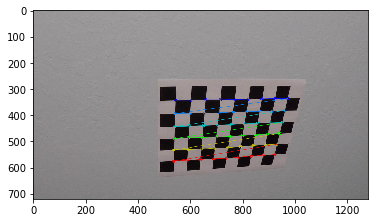

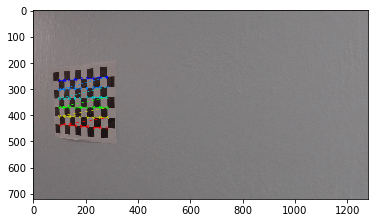

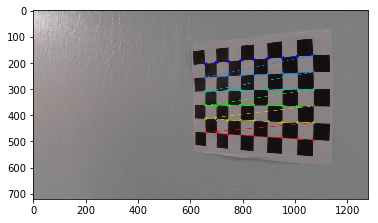

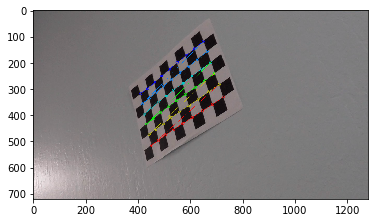

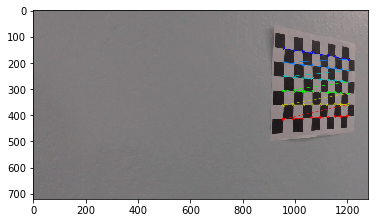

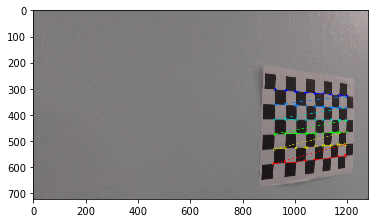

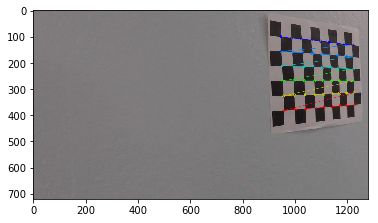

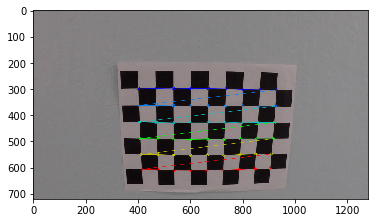

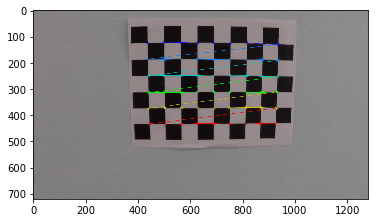

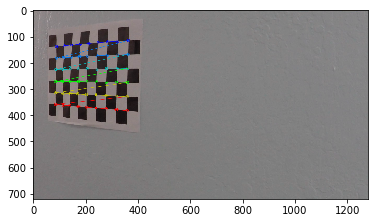

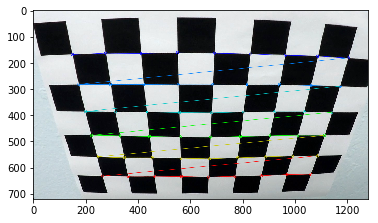

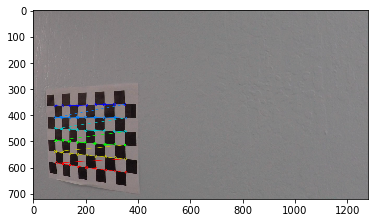

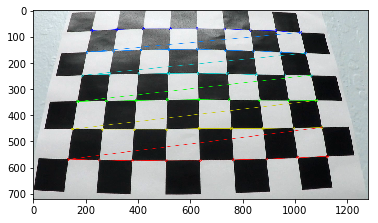

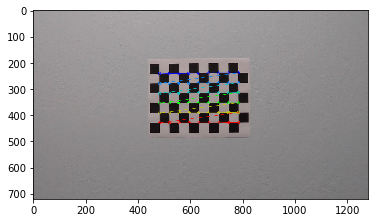

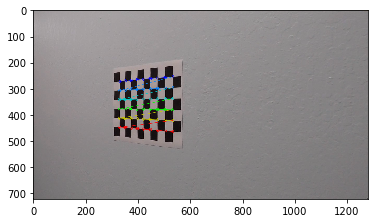

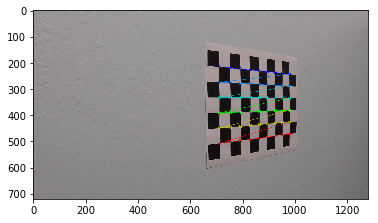

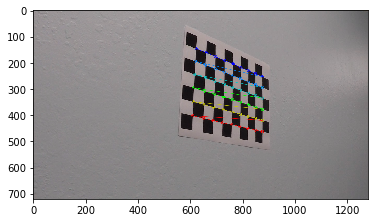

In [4]:
ret, mtx, dist, rvecs, tvecs = camera_calibration(verbose=True)

# Displaying undistorted images

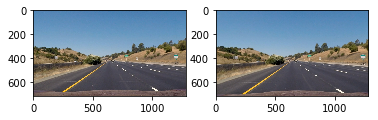

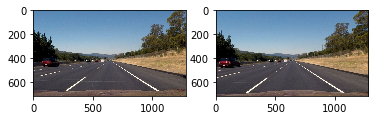

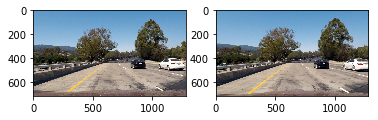

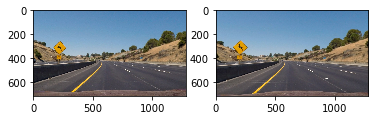

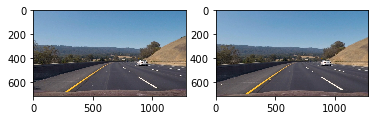

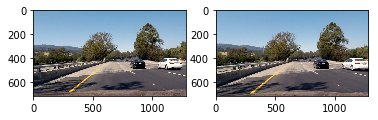

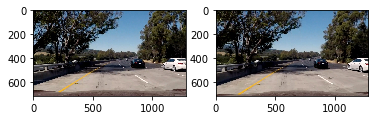

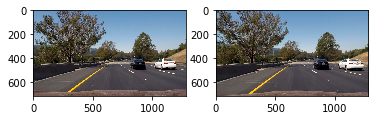

In [5]:
undistort_images(mtx, dist)

# Image Thresholding
Going to implement image thresholding here. This will be used to find the lanes.

In [6]:
"""
Acquires the Sobel Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Sobel(gray, thres = (20, 100), kernel = 3):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    abs_sobelx = np.absolute(x)
    abs_sobely = np.absolute(y)
    
    # rescaling to 8 bit
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    # print(scaled_sobelx.shape)
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    # print(scaled_sobely.shape)
    
    sobel_binx = np.zeros_like(scaled_sobelx)
    sobel_binx[((scaled_sobelx >= thres[0]) & (scaled_sobelx <= thres[1]))] = 1
    
    sobel_biny = np.zeros_like(scaled_sobely)
    sobel_biny[((scaled_sobely >= thres[0]) & (scaled_sobely <= thres[1]))] = 1
    
    return sobel_binx, sobel_biny
    
"""
Acquires the Magnitude of the  Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Magnitude(gray, thres = (20, 100), kernel = 3):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Gradient Magnitude
    magnitude = np.sqrt(x**2 + y**2)
    
    # rescaling to 8 bit
    scaled_magnitude = np.max(magnitude)/255
    magnitude = np.uint8(magnitude / scaled_magnitude)
    # print(magnitude.shape)
    mag_bin = np.zeros_like(magnitude)
    mag_bin[((magnitude >= thres[0]) & (magnitude <= thres[1]))] = 1
    return mag_bin

"""
Acquires the Direction of the Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Direction(gray, thres = (0.7, 1.3), kernel = 15):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Gradient Direction
    direction = np.arctan2(np.absolute(y), np.absolute(x))
    dir_bin = np.zeros_like(direction)
    dir_bin[((direction >= thres[0]) & (direction <= thres[1]))] = 1
    return dir_bin

"""
Combine Thresholds, excluding S channel

param sobelx: Sobel Binary on X axis
param sobely: Sobel Binary on Y axis
param magnitude: Magnitude of Gradient
param direction: Direction of Gradient
param verbose: If True, displays all inputs and output
return: Binary Image 
"""
def Combine(sobelx, sobely, magnitude, direction, verbose = False):
    # print(direction.shape)
    output = np.zeros_like(direction)
    output[(((sobelx == 1) & (sobely == 1)) | ((magnitude == 1) & (direction == 1)))]= 1
    
    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(sobelx, cmap = "gray")
        ax[0].set_title("sobel_binx")
        ax[1].imshow(sobely, cmap = "gray")
        ax[1].set_title("sobel_biny")
        
        fig2, ax2 = plt.subplots(nrows=1, ncols=2)
        ax2[0].imshow(magnitude, cmap = "gray")
        ax2[0].set_title("magnitude")
        ax2[1].imshow(direction, cmap = "gray")
        ax2[1].set_title("direction")
        fig3, ax3 = plt.subplots(nrows=1, ncols=1)
        ax3.imshow(output, cmap = "gray")
        ax3.set_title("Gradient Binary")
        plt.show()
        
    return output

In [7]:
"""
Isolates the S channel in HLS space, and returns a binary image.

param img: BGR image
param verbose: If True, displays the binary image
return: Binary image with S channel isolated
"""
def colorThresh(img, thresS = (90, 255), verbose = False):
    #hls
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # isolating the S channel
    S = hls[:,:,2]
    S_bin = np.zeros_like(S)
    S_bin[((S >= thresS[0]) & (S <= thresS[1]))] = 1
    
    # selected threshold to highlight yellow lines
    yellow_min = np.array((0, 70, 70))
    yellow_max = np.array((50, 255, 255))
    
    #hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    min_yellow = np.all(hsv > yellow_min, axis=2)
    max_yellow = np.all(hsv < yellow_max, axis=2)

    yellow = np.logical_and(min_yellow, max_yellow)
    
    # selected threshold to highlight yellow lines
    white_min = np.array((0, 0, 200))
    white_max = np.array((255, 20, 255))
    
    min_white = np.all(hsv > white_min, axis=2)
    max_white = np.all(hsv < white_max, axis=2)

    white = np.logical_and(min_white, max_white)
    
    out = np.zeros_like(S_bin)
    out[((yellow == 1) | (S_bin == 1) | (white == 1))] = 1

    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(S, cmap = "gray")
        ax[0].set_title("S Channel")
        ax[1].imshow(S_bin, cmap = "gray")
        ax[1].set_title("S Channel Isolated Binary")
        plt.show()
        
        
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(out, cmap = "gray")
        ax[0].set_title("out")
        ax[1].imshow(yellow, cmap = "gray")
        ax[1].set_title("yellow")
        plt.show()
        
    return out

In [8]:
"""
Transforms input image to highlight the lanes lines as much as possible

param img: undistorted image
param verbose: if True, visualize transformation process
return: binary image
"""
def transform_image(img, thresS = (90, 255), verbose = False):
    height, width = img.shape[:2]
    
    #grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx, sobely = Sobel(gray, thres = (20, 100), kernel = 3)
    magnitude = Magnitude(gray, thres = (30, 100), kernel = 3)
    direction = Direction(gray, kernel = 15)
    color = colorThresh(img, thresS = thresS, verbose=verbose)
    gradient = Combine(sobelx, sobely, magnitude, direction, verbose = verbose)
    
    combined = np.zeros_like(gradient)
    combined[((gradient == 1) | (color == 1))] = 1
    
    if verbose:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Input")
        plt.show()
        plt.imshow(combined, cmap = "gray")
        plt.title("Thresholded Binary")
        plt.show()
        
    return combined

# Perspective Transform
I am implementing perspective transform here to get a bird's eye view of the road.

In [9]:
"""
Applies a perspective transform to the provided image.

param img: Undistorted image
param verbose: If True, will display transformed image
return: Warped image
"""
def perspective_transform(img, verbose = False):
    # defining calibration box in source and destination coordinates
    # height, width
    height, width = img.shape[:2]
    
    # print(img_size)
    offset_y = 10
    
    
    # 4 source coordinates for transform
    p1 = [732, 460] # topRx, topRy INC
    p2 = [width, height - offset_y]# bottomRx, bottomRy
    p3 = [0, height - offset_y]# bottomLx, bottomLy
    p4 = [546, 460]# topLx, topLy DEC
    
    # the source points for the lane lines 
    src = np.float32([p1, p2, p3, p4])
    
    # the destination points that define how the new image should look
    # [350, 350], [930, 720], [350, 720], [930, 350]
    dst = np.float32([[width, 0],
                      [width, height],
                      [0, height],
                      [0, 0]])
    """
    
    # 4 source coordinates for transform
    p1 = [716, 468] # topRx, topRy INC
    p2 = [1122, height]# bottomRx, bottomRy
    p3 = [198, height]# bottomLx, bottomLy
    p4 = [569, 468]# topLx, topLy DEC
    
    # the source points for the lane lines 
    src = np.float32([p1, p2, p3, p4])
    
    # the destination points that define how the new image should look
    # [350, 350], [930, 720], [350, 720], [930, 350]
    offset = 350
    
    dst = np.float32([[width-offset, offset],
                      [width-offset, height],
                      [offset, height],
                      [offset, offset]])
    """
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    # applies a transform to the original image
    warped =  cv2.warpPerspective(img, M, (width, height), flags = cv2.INTER_LINEAR)
    
    if verbose:
        # print(warped.shape)
        # plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY))
        plt.imshow(warped, cmap = "gray")
        plt.title("Bird's Eye View")
        plt.show()
    
    return warped, M

In [10]:
"""
Returns a Column-wise Sum of pixels in binary image.

param img: Binary, Transformed Image
param divisor: Specifies which lower fraction of image to return histogram of
return: Array of pixel xount per column
"""
def Histogram(img, divisor = 2):
    return np.sum(img[np.int(img.shape[0]/divisor):,:], axis=0)

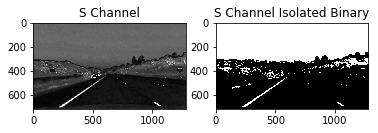

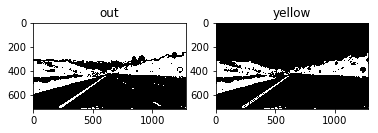

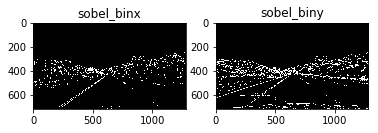

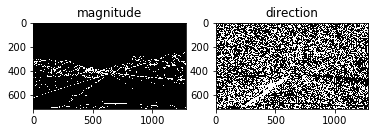

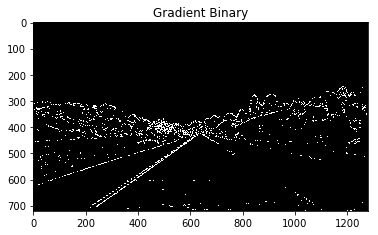

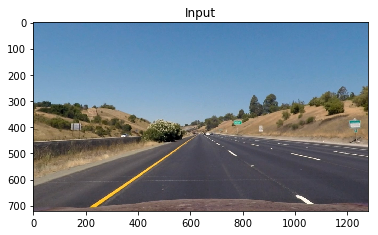

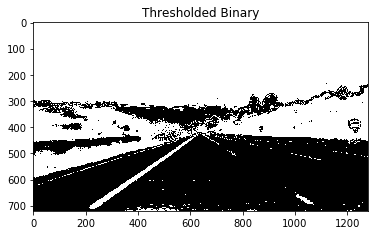

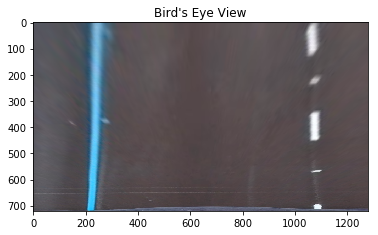

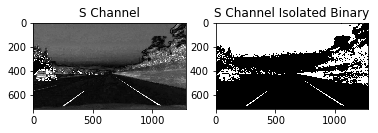

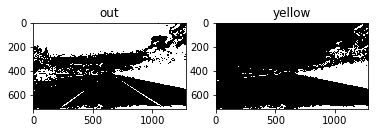

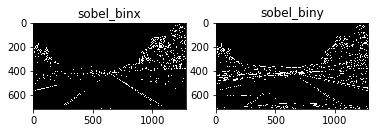

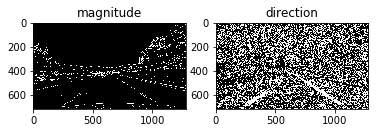

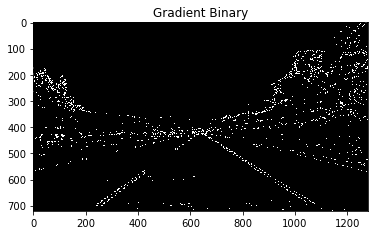

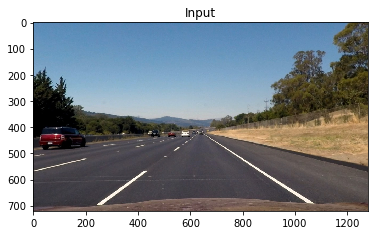

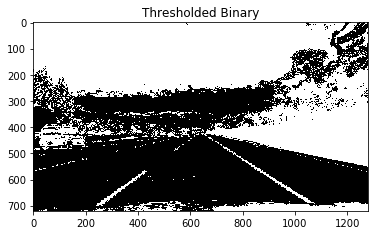

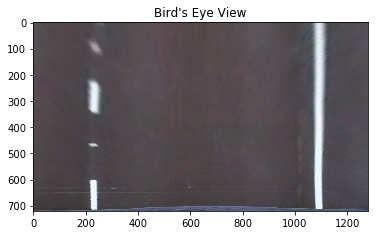

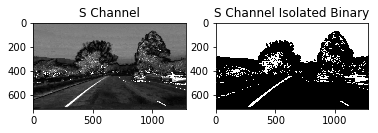

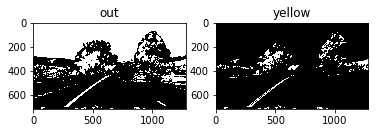

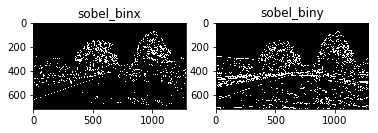

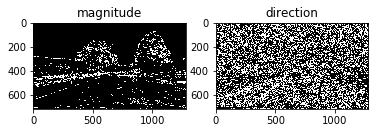

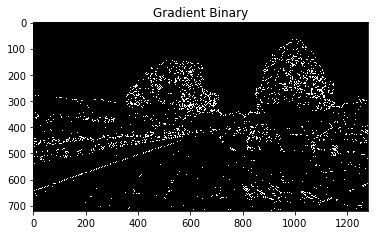

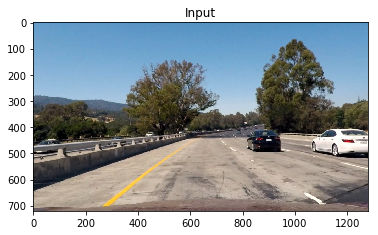

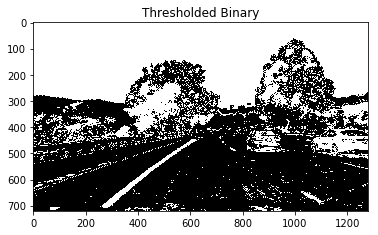

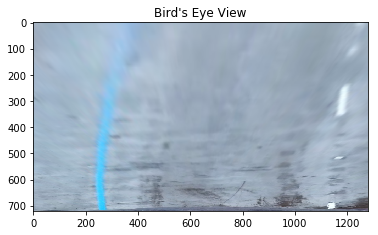

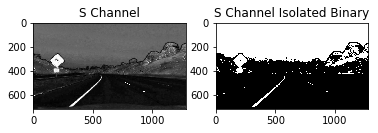

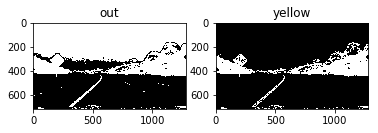

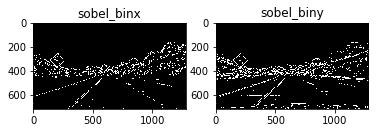

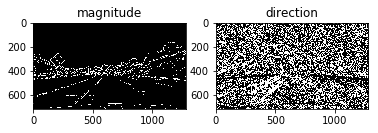

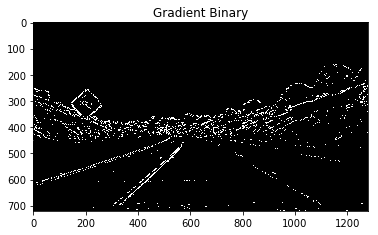

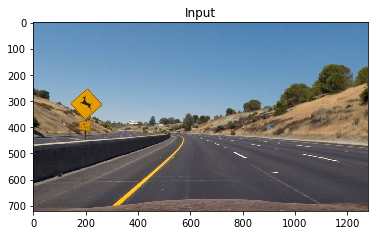

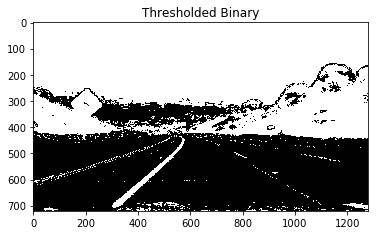

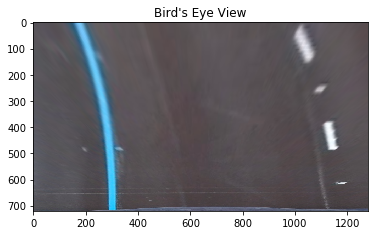

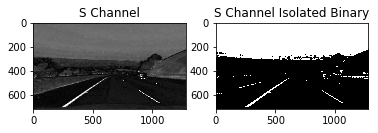

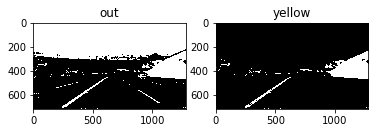

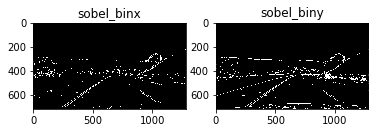

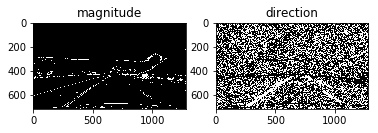

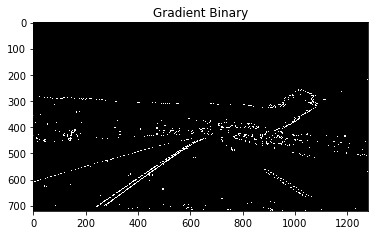

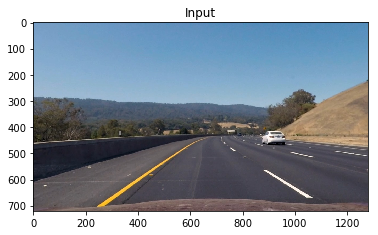

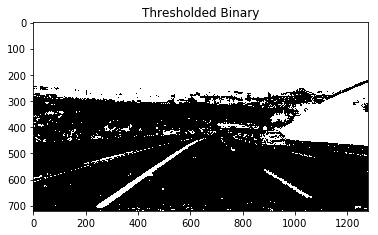

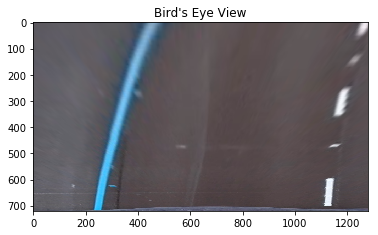

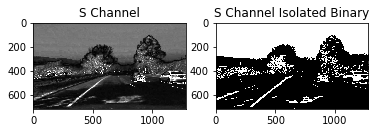

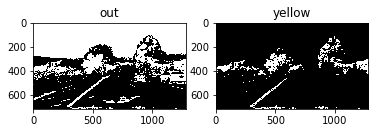

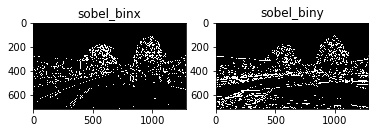

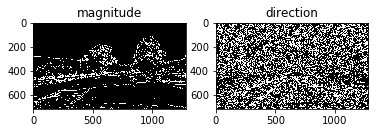

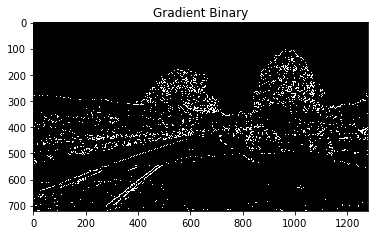

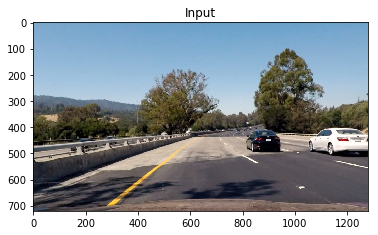

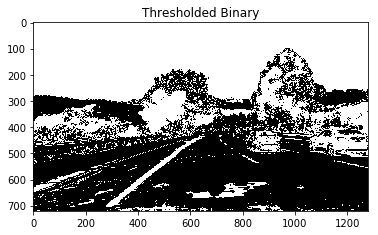

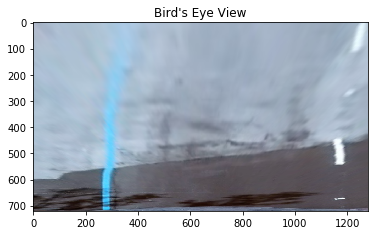

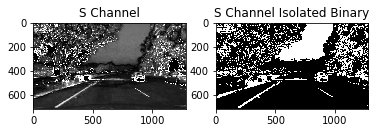

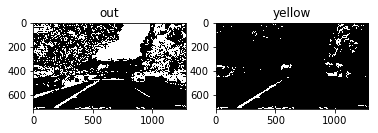

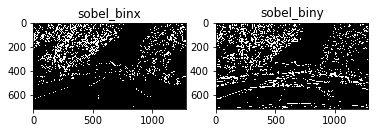

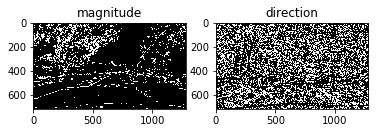

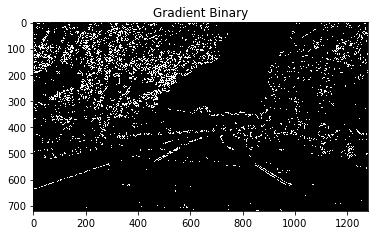

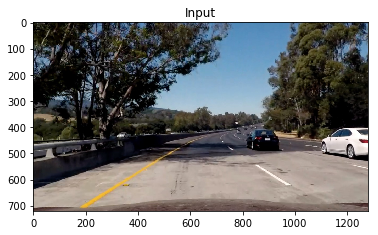

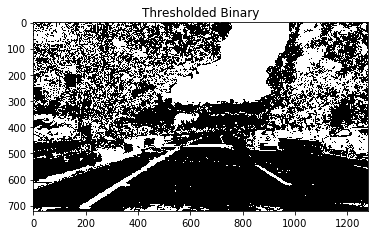

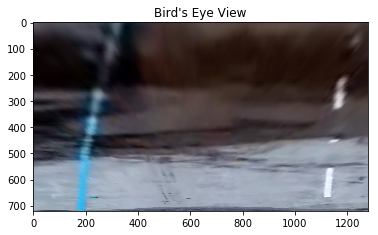

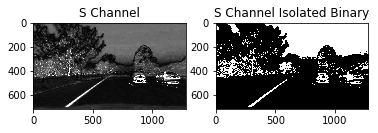

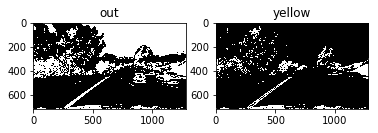

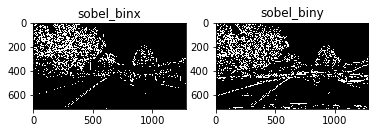

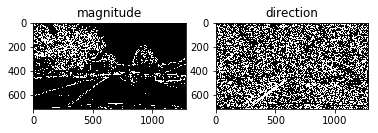

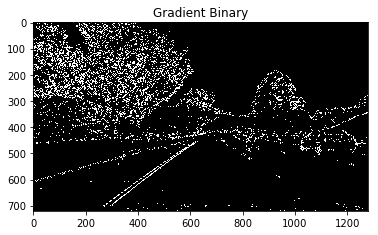

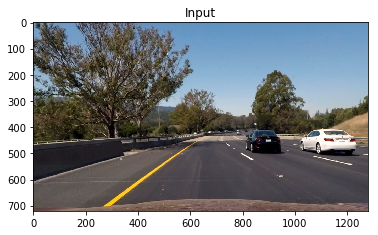

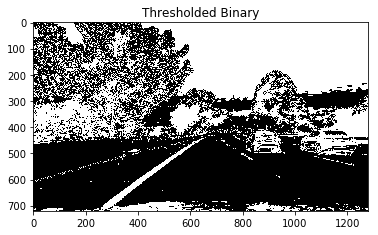

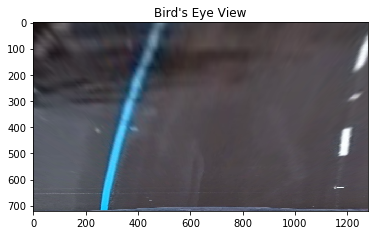

In [11]:
test_images = glob.glob('test_images/*.jpg')
birdseye_bgr = []
birdseye_bin = []

for file in test_images:
    img = cv2.imread(file)
    img = undistort_image(img, mtx, dist)
    
    threshold = transform_image(img, verbose = True)
    # transformed = perspective_transform(threshold, verbose = True)
    
    warped, M = perspective_transform(img, verbose = True)
    threshold2 = transform_image(warped, thresS = (180, 255), verbose = False)
    
    # histogram = Histogram(threshold2, 2)
    
    # plt.plot(histogram)
    # plt.show()
    
    # transformed_view.append(threshold)
    birdseye_bin.append((threshold2, M, img, threshold))
    birdseye_bgr.append(warped)

# Lane Finding
This portion concerns finding the location of lanes in each image.

In [12]:
# making sure I have the right number of images
assert len(birdseye_bin) == len(birdseye_bgr), "Length of transformed_view != Length of birdseye"

In [13]:
def window_mask(width, height, img_ref, center, level, verbose = False):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1)* height) : int(img_ref.shape[0] - level * height),
           max(0, int(center - width / 2)):min(int(center + width / 2), img_ref.shape[1])] = 1
    
    """
    if verbose:
        plt.imshow(output)
        plt.show()
    """
    
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    # print(image.shape)
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def sliding_window(binary, window_width, window_height, margin, verbose = False):
    
    # plt.imshow(binary)
    # plt.show()
    
    binary = np.delete(binary, np.s_[700:], 0)
    
    # plt.imshow(binary)
    # plt.show()
    
    window_centroids = find_window_centroids(binary, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary)
        r_points = np.zeros_like(binary)

        # Go through each level and draw the windows 	
        for level in range(0, len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width, window_height, binary, window_centroids[level][0], level)
            r_mask = window_mask(window_width, window_height, binary, window_centroids[level][1], level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points + l_points).astype(np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        # template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        template = np.dstack((zero_channel,template,zero_channel)).astype(np.uint8)
        # warpage = np.array(cv2.merge((binary,binary,binary)),np.uint8) # making the original road pixels 3 color channels
        warpage = (np.dstack((binary, binary, binary)) * 255).astype(np.uint8)
        # output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        output = np.minimum(template, warpage)
        
        """
        plt.imshow(template)
        plt.show()
        
        plt.imshow(warpage)
        plt.show()
        """
        
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # plotting
    # print("all", output.nonzero())
    # print(output.shape)
    
    split = np.hsplit(output, 2)
    left = split[0].nonzero()
    lefty = left[0]
    leftx = left[1]
    right = split[1].nonzero()
    righty = right[0]
    rightx = right[1] + 640
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if verbose:
        # Display the final results
        plt.imshow(output)
        plt.title('window fitting results')
        plt.show()
    
    return output, left_fit, right_fit

def visualize(binary, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0] - 1, binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # binary[nonzeroy[leftLane], nonzerox[leftLane]] = [255, 0, 0]
    # binary[nonzeroy[rightLane], nonzerox[rightLane]] = [0, 0, 255]
    
    plt.imshow(binary)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.show()

# Finding Lane Lines below
The above code does well at finding lanes and isolating them. However, it is not very effective. 

Using the code below.

In [14]:
def Find_Lane_Start(binary, M, image, windows = 9, margin = 100, minpix = 50, verbose = False):
    # plt.imshow(binary_warped, cmap = "gray")
    # plt.show()
    
    histogram = Histogram(binary, 2)
    # plt.plot(histogram)
    # plt.show()
    
    # Create an output image to draw on and  visualize the result
    # this bug has been bothering me for the longest time
    # must set .astype(np.uint8) else you get a 3d array of floats which opencv won't work with
    # there is no exception thrown for bad input by opencv
    drawing = (np.dstack((binary, binary, binary)) * 255).astype(np.uint8)
    # drawing = np.array(drawing)
    
    # print(drawing.shape)
    # print((drawing == [255, 255, 255]).sum(), "lane pixels")
    # print(drawing)
    
    # plt.imshow(drawing, cmap="gray")
    # plt.show()
        
    # splitting the histogram and finding the left and right starting pixels
    midpoint = np.int(histogram.shape[0] / 2)
    baseL = np.argmax(histogram[:midpoint])
    baseR = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    height = np.int(binary.shape[0] / windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    currentL = baseL
    currentR = baseR
    
    # Create empty lists to receive left and right lane pixel indices
    leftLane = []
    rightLane = []

    # Step through the windows one by one
    for window in range(windows):
        # Identify window boundaries in x and y (and right and left)
        y_low = binary.shape[0] - (window + 1) * height
        y_high = binary.shape[0] - window * height
        
        xleft_low = currentL - margin
        xleft_high = currentL + margin
        
        xright_low = currentR - margin
        xright_high = currentR + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(drawing,(xleft_low, y_low),(xleft_high, y_high), (0,255,0), 2) 
        cv2.rectangle(drawing,(xright_low, y_low),(xright_high, y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        left = ((nonzeroy >= y_low) & (nonzeroy < y_high) & 
                (nonzerox >= xleft_low) & (nonzerox < xleft_high)).nonzero()[0]
        right = ((nonzeroy >= y_low) & (nonzeroy < y_high) & 
                 (nonzerox >= xright_low) & (nonzerox < xright_high)).nonzero()[0]
        
        # print("left", left)
        # print("right", right)
        
        # Append these indices to the lists
        leftLane.append(left)
        rightLane.append(right)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left) > minpix:
            currentL = np.int(np.mean(nonzerox[left]))
        if len(right) > minpix:        
            currentR = np.int(np.mean(nonzerox[right]))

    # Concatenate the arrays of indices
    leftLane = np.concatenate(leftLane)
    rightLane = np.concatenate(rightLane)

    # Extract left and right line pixel positions
    leftx = nonzerox[leftLane]
    lefty = nonzeroy[leftLane] 
    
    rightx = nonzerox[rightLane]
    righty = nonzeroy[rightLane] 
    
    # print("leftx", leftx)
    # print("lefty", leftx)
    # print("rightx", leftx)
    # print("righty", leftx)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, drawing.shape[0] - 1, drawing.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    drawing[nonzeroy[leftLane], nonzerox[leftLane]] = [255, 0, 0]
    drawing[nonzeroy[rightLane], nonzerox[rightLane]] = [0, 0, 255]
    
    """
    fig = plt.gcf()
    fig_size = fig.get_size_inches()
    
    w, h, d = drawing.shape
    # w2,h2 = fig_size[0],fig_size[1]
    # fig.set_size_inches([(w2/w)*w,(w2/w)*h])
    # fig.set_dpi((w2/w)*fig.get_dpi())
    
    fig.patch.set_alpha(0)
    a = fig.gca()
    a.set_frame_on(False)
    a.set_xticks([]); a.set_yticks([])
    plt.axis('off')
    
    plt.savefig("output_images/plotted-birdseye.png", bbox_inches='tight', pad_inches=0)
    """
    
    if verbose:
        plt.imshow(drawing)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # print(ym_per_pix)
    # print(xm_per_pix)

    """
    # Fit new polynomials to x,y in meters
    print(lefty)
    print(lefty * ym_per_pix)
    print(leftx)
    print(leftx * xm_per_pix)

    print()

    print(righty)
    print(righty * ym_per_pix)
    print(rightx)
    print(rightx * xm_per_pix)
    """

    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # print(left_fit[0], " ", left_fit[1], " ", left_fit[2])
    # print(left_fit_cr[0], " ", left_fit_cr[1], " ", left_fit_cr[2])

    # print(right_fit[0], " ", right_fit[1], " ", right_fit[2])
    # print(right_fit_cr[0], " ", right_fit_cr[1], " ", right_fit_cr[2])

    left_fitxc = left_fit_cr[0] * ploty ** 2 + left_fit_cr[1] * ploty + left_fit_cr[2]
    right_fitxc = right_fit_cr[0] * ploty ** 2 + right_fit_cr[1] * ploty + right_fit_cr[2]

    """
    plt.plot(left_fitxc, ploty, color='green')
    plt.plot(right_fitxc, ploty, color='purple')
    plt.xlim(0, 7)
    plt.ylim(30, 0)
    plt.show()
    """

    # point where I am evaluating
    y_eval = 719

    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) 
                     ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) 
                       ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
        
    right_avg = np.average(rightx)
    left_avg = np.average(leftx)
    
    lane_center = (right_avg + left_avg) / 2
    center_offset = np.absolute(((1280 / 2) - lane_center) * xm_per_pix)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
    if verbose:
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
        print("center_offset", center_offset)
        
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()
        
    return drawing, left_curverad, right_curverad, result, center_offset, left_fit, right_fit
    
def find_lane(binary, M, image, left_fit, right_fit, margin = 100, verbose = False):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] 
                                   - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * 
                                                             nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] 
                                      + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary, binary, binary))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    drawing = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if verbose:
        plt.imshow(drawing)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    left_fitxc = left_fit_cr[0] * ploty ** 2 + left_fit_cr[1] * ploty + left_fit_cr[2]
    right_fitxc = right_fit_cr[0] * ploty ** 2 + right_fit_cr[1] * ploty + right_fit_cr[2]

    
    # point where I am evaluating
    y_eval = 719

    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) 
                     ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) 
                       ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
        
    right_avg = np.average(rightx)
    left_avg = np.average(leftx)
    
    lane_center = (right_avg + left_avg) / 2
    center_offset = np.absolute(((1280 / 2) - lane_center) * xm_per_pix)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
    if verbose:
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
        print("center_offset", center_offset)
        
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()

    return drawing, left_curverad, right_curverad, result, center_offset, left_fit, right_fit

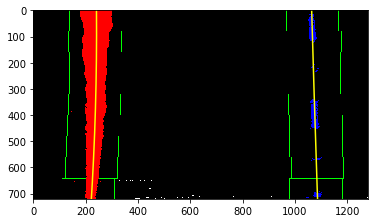

2702.62559009 m 34372.9944262 m
center_offset 0.0707251702281


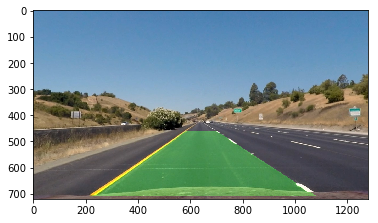

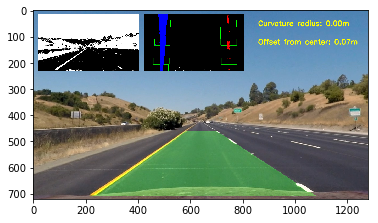

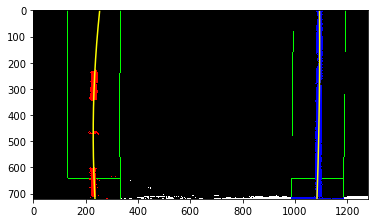

1174.59981135 m 4315.4032024 m
center_offset 0.101707618744


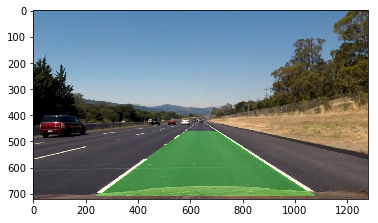

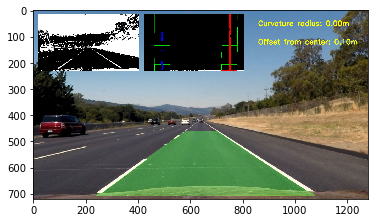

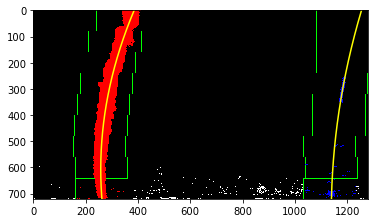

377.099108092 m 685.775428433 m
center_offset 0.413055618952


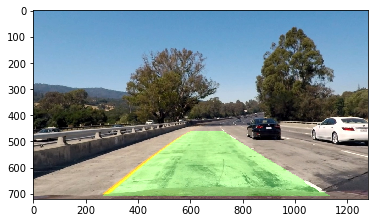

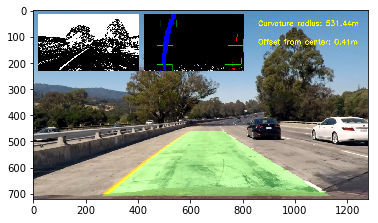

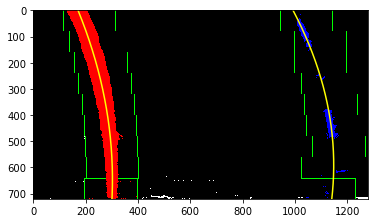

413.795533632 m 293.565857618 m
center_offset 0.168475866268


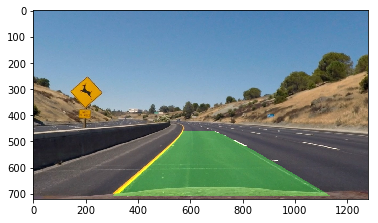

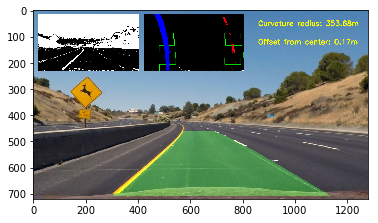

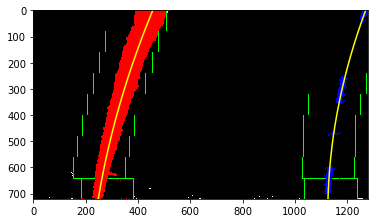

765.767564611 m 547.860454642 m
center_offset 0.564054704461


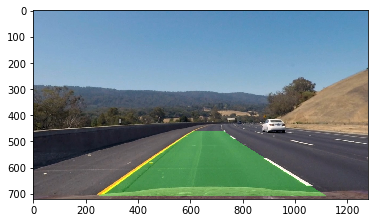

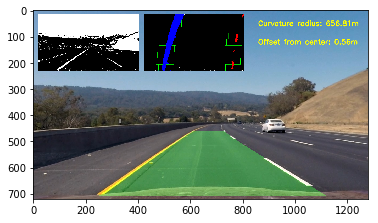

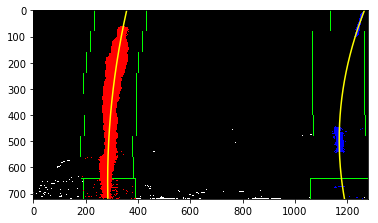

763.72928553 m 330.944029127 m
center_offset 0.492289184918


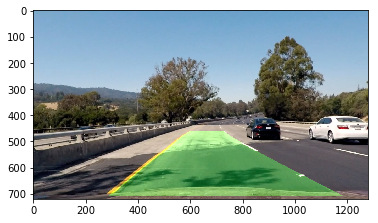

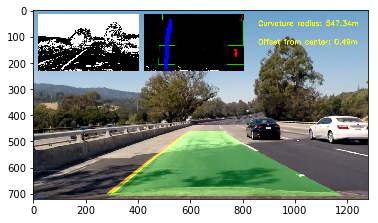

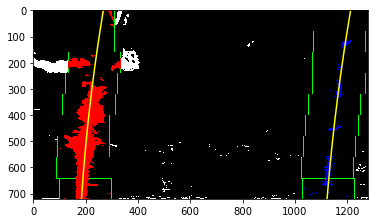

1864.95326952 m 2116.29421382 m
center_offset 0.185300917289


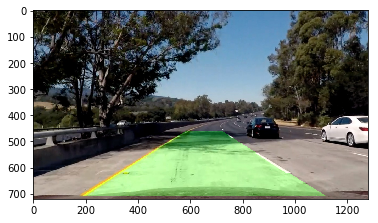

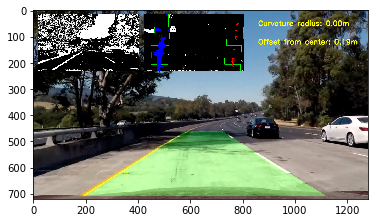

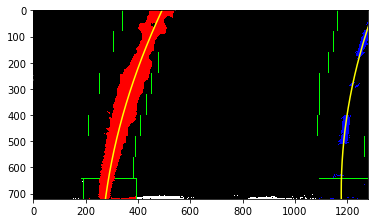

566.211741881 m 502.509078494 m
center_offset 0.716269707914


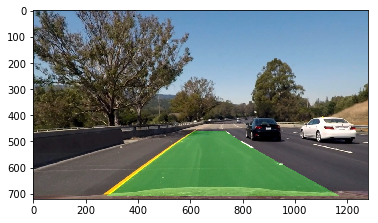

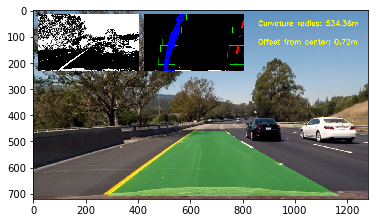

In [15]:
def illustrate(road_img, binary, birdseye, left_curverad, right_curverad, offset):
    h, w = road_img.shape[:2]

    thumb_ratio = 0.3
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = road_img.copy()
    mask = cv2.rectangle(mask, pt1 = (0, 0), pt2 = (w, thumb_h + 2 * off_y), color = (0, 0, 0), 
                         thickness = cv2.FILLED)
    blend_on_road = cv2.addWeighted(src1 = mask, alpha = 0.2, src2 = road_img, beta = 0.8, gamma = 0)

    # add thumbnail of binary image
    thumb_binary = cv2.resize(binary, dsize = (thumb_w, thumb_h))
    thumb_binary = (np.dstack([thumb_binary, thumb_binary, thumb_binary]) * 255).astype(np.uint8)
    road_img[off_y : thumb_h + off_y, off_x : off_x + thumb_w, :] = thumb_binary

    # add thumbnail of bird's eye view
    thumb_img_fit = cv2.resize(birdseye, dsize=(thumb_w, thumb_h))

    road_img[off_y:thumb_h+off_y, 2*off_x+thumb_w:2*(off_x+thumb_w), :] = thumb_img_fit

    # add text (curvature and offset info) on the upper right of the blend
    mean_curvature_meter = np.mean([left_curverad, right_curverad])
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if(mean_curvature_meter > 1100):
        mean_curvature_meter = 0
    
    cv2.putText(road_img, 'Curvature radius: {:.02f}m'.format(mean_curvature_meter), (860, 60), 
                font, 0.9, (0, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(road_img, 'Offset from center: {:.02f}m'.format(offset), (860, 130), font, 0.9, 
                (0, 255, 255), 2, cv2.LINE_AA)
    
    return road_img

for img, M, image, binary in birdseye_bin:
    drawing, left_curverad, right_curverad, result, offset, Lfit, Rfit = Find_Lane_Start(img, M, image, windows = 9,  
                                                                             verbose = True)
    
    result = illustrate(result, binary, drawing, left_curverad, right_curverad, offset)
    
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()
    
    """
    # Sliding Window Implementation
    
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 2 # How much to slide left and right for searching
    output, left_fit, right_fit = sliding_window(img, window_width, window_height, margin, verbose = True)
    visualize(output, left_fit, right_fit)
    """

In [16]:
processed = False
count = 0
left_fit = None
right_fit = None
ret = None
mtx = None
dist = None
rvecs = None
tvecs = None

In [17]:
"""
This will be the pipeline for the videos

It just combines all of the methods defined so far.

There is obvious lag. It can be improved.

It uses the above class variables
"""

def pipeline(img, verbose = False):
    
    global processed, left_fit, right_fit, ret, mtx, dist, rvecs, tvecs, count
    
    
    if processed == False:
        r, m, d, rv, tv = camera_calibration()
        ret = r 
        mtx = m
        dist = d
        rvecs = rv
        tvecs = tv
        processed = True
    
    undistorted = undistort_image(img, mtx, dist)
    
    threshold = transform_image(undistorted)
    # transformed = perspective_transform(threshold, verbose = True)
    
    warped, M = perspective_transform(undistorted)
    threshold2 = transform_image(warped, thresS = (180, 255))
    
    # threshold2, M, img, threshold = img, M, image, binary
    
    if count == 0:
        drawing, left_curverad, right_curverad, result, offset, Lfit, Rfit = Find_Lane_Start(threshold2, M, 
                                                                                             undistorted, 
                                                                                             windows = 9)
        processed = True
        left_fit = Lfit
        right_fit = Rfit
        count += 1 
        
    else:
        drawing, left_curverad, right_curverad, result, offset, Lfit, Rfit = find_lane(threshold2, M, 
                                                                                       undistorted, left_fit, 
                                                                                       right_fit)
        
        left_fit = Lfit
        right_fit = Rfit
        
    result = illustrate(result, threshold, drawing, left_curverad, right_curverad, offset)
    
    
    if verbose: 
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()

    return result
    

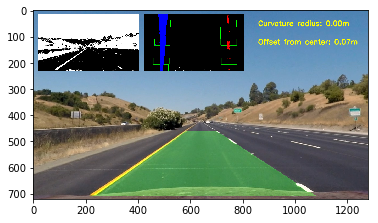

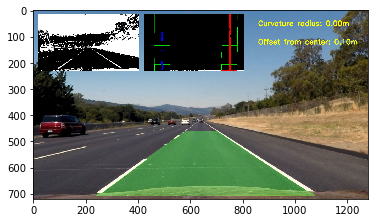

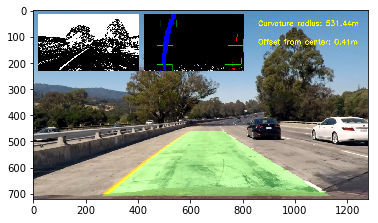

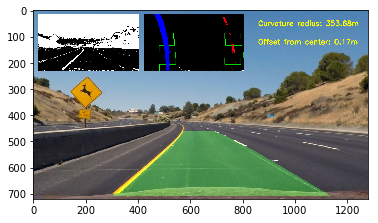

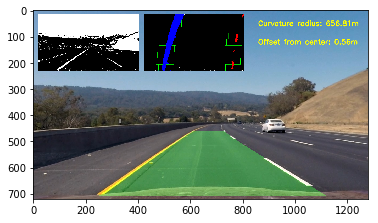

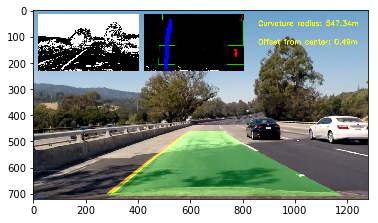

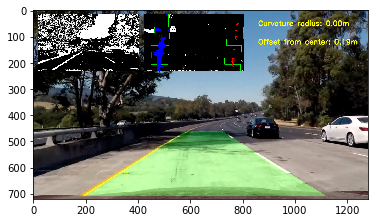

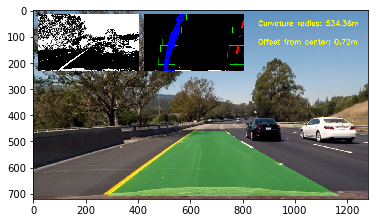

In [18]:
for file in test_images:
    img = cv2.imread(file)
    pipeline(img, verbose = True)
    count = 0

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip # getting error here
from IPython.display import HTML # works just fine

C:\Tools\Anaconda3\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [20]:
video_output = 'project_video_complete.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

C:\Tools\Anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_complete.mp4
----------------------------------------

Writing video into project_video_complete.mp4
Done writing video in project_video_complete.mp4 !                       
Your video is ready !
Wall time: 15min 28s
